<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_Enfermedad_en_la_sangre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Enfermedad en la sangre

**Nombre**: Pablo Saavedra <br />
**Curso**: Modelos avanzados y Redes Neuronales (G105)


---

### Importación de librerías

In [67]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def eval_model_short(name, model):
  y_pred = model.predict(X_test)
  # Para AUC necesitamos probas de clase 1
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

  print(f"{name:>18} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import mode


def bagging_het(X_train, y_train, T, estimators, X_test):
    """
    Crea un modelo Bagging usando estimadores heterogéneos.
    En que genera una cantidad T de muestras bootstrap y
    para cada una de ellas se entrena un estimador escogido
    en forma aleatoria desde la bolsa disponible.
    La estimación final usando los modelos entrenados se
    realiza por mayoría de votos.

    Basado en

    Parámetros:
    -----------
    X_train : DataFrame
        Conjunto de entrenamiento sin columna target.
    y_train : Series
        Datos con las clases asociadas a cada obs. de X_train
    T : int
        Representa la cantidad de muestras bootstrap a generar,
        equivalente a la cantidad de estimadores a entrenar.
    X_test : DataFrame
        Conjunto de test sobre el cual se somete el ensamble

    Retorna:
    --------
    list
        Lista con los estimadores entrenados

    np.array
        Array con cantidad de filas igual a la cantidad de
        observaciones de X_test y T columnas cada una con
        la clasificación predicha por el estimador asignado

    Series
        resultado por mayoría de votos para el conjunto de test

    list
        Lista con los índices no repetidos de las observaciones
        excluidad en cada muestra bootstrap
    """

    trained_model = []
    yhat_test = np.zeros((X_test.shape[0], T))
    idx_oob = []
    for t in np.arange(0, T):
        sa1 = X_train.sample(n=X_train.shape[0], replace=True)

        idx_oob = list(set(idx_oob + list(set(X_train.index)-set(sa1.index))))

        idx_estimator = np.random.randint(0, len(estimators))
        estimator = estimators[idx_estimator]
        #print(idx_estimator, end='; ')

        estimator.fit(sa1, y_train[sa1.index])
        trained_model.append(estimator)

        yhat_test[:,t] = estimator.predict(X_test)

    yhat_out = pd.Series(data=mode(yhat_test, axis=1)[0], name='yhat')

    return trained_model, yhat_test, yhat_out, idx_oob


def bagging_het_predict(X, estimators):
    yhat = np.zeros((X.shape[0], len(estimators)))

    for i, est in enumerate(estimators):
        yhat[:,i] = est.predict(X)

    return pd.Series(data=mode(yhat, axis=1)[0], name='yhat')

In [4]:
from typing import Optional, Iterable, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

def eval_model_preds(
    X_train, y_train,
    X_test,  y_test,
    y_pred_train,
    y_pred_test,
    class_names: Optional[Iterable[str]] = None,
    *,
    normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
    average: str = "weighted",           # "macro" | "weighted" | "micro"
    plot: bool = True,
    title_prefix: str = "",
    # scores para binario (p.ej. proba[:,1] o decision_function)
    pos_scores_train: Optional[np.ndarray] = None,
    pos_scores_test: Optional[np.ndarray] = None,
    binary_threshold: Optional[float] = None,  # si no None y hay scores, recalcula y_pred
    zero_division: int = 0,
    label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
    """
    Evalúa un clasificador en train/test con métricas y (opcional) gráficos,
    recibiendo predicciones ya calculadas (sin pasar el modelo).

    - y_pred_train/y_pred_test: predicción final (clase).
    - pos_scores_* (opcional): scores de clase positiva para AUC/ROC/PR (binario).
    """

    # ---------------------------
    # 0) Preparación / tipos
    # ---------------------------
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    y_pred_train = np.asarray(y_pred_train)
    y_pred_test  = np.asarray(y_pred_test)

    target_kind = type_of_target(y_test)
    is_binary = target_kind == "binary"

    # Si viene un mapeo explícito, aplícalo a y_* reales
    if label_map is not None:
        y_train = np.vectorize(label_map.get)(y_train)
        y_test  = np.vectorize(label_map.get)(y_test)

    # Si hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
    def _needs_alignment(y_true, y_pred):
        return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

    if _needs_alignment(y_test, y_pred_test):
        if not is_binary:
            raise TypeError(
                "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
                "Pasa 'label_map' o codifica etiquetas (LabelEncoder)."
            )
        if class_names is not None and len(list(class_names)) == 2:
            auto_map = {list(class_names)[0]: 0, list(class_names)[1]: 1}
            y_train = np.vectorize(auto_map.get)(y_train)
            y_test  = np.vectorize(auto_map.get)(y_test)
        else:
            uniq = list(np.unique(y_train))
            if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
                auto_map = {uniq[0]: 0, uniq[1]: 1}
                y_train = np.vectorize(auto_map.get)(y_train)
                y_test  = np.vectorize(auto_map.get)(y_test)
            else:
                raise TypeError(
                    "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                    "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
                )

    # ---------------------------
    # 1) Umbral binario (si aplica) usando scores
    # ---------------------------
    if is_binary and (pos_scores_train is not None or pos_scores_test is not None) and (binary_threshold is not None):
        thr = float(binary_threshold)
        if pos_scores_train is not None:
            y_pred_train = (np.asarray(pos_scores_train) >= thr).astype(int)
        if pos_scores_test is not None:
            y_pred_test  = (np.asarray(pos_scores_test)  >= thr).astype(int)

    # ---------------------------
    # 2) Métricas numéricas
    # ---------------------------
    metrics: Dict[str, Any] = {}

    def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=average, zero_division=zero_division
        )
        mcc = matthews_corrcoef(y_true, y_pred)
        return {
            f"{split}_accuracy": acc,
            f"{split}_balanced_accuracy": bacc,
            f"{split}_precision_{average}": p,
            f"{split}_recall_{average}": r,
            f"{split}_f1_{average}": f1,
            f"{split}_mcc": mcc
        }

    metrics.update(block_metrics(y_train, y_pred_train, "train"))
    metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

    # AUCs si tenemos scores (binario)
    if is_binary and (pos_scores_test is not None):
        try:
            if pos_scores_train is not None:
                metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
                metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
            metrics["test_roc_auc"] = roc_auc_score(y_test, pos_scores_test)
            metrics["test_pr_auc"]  = average_precision_score(y_test, pos_scores_test)
        except Exception:
            pass

    # ---------------------------
    # 3) Reportes por clase
    # ---------------------------
    prefix = (title_prefix + " ") if title_prefix else ""
    print(prefix + "Reporte de clasificación (train):")
    print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
    print(prefix + "Reporte de clasificación (test):")
    print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

    # ---------------------------
    # 4) Gráficos
    # ---------------------------
    if plot:
        has_scores = is_binary and (pos_scores_test is not None)
        fig, axes = (plt.subplots(2, 2, figsize=(10, 8)) if has_scores
                     else plt.subplots(1, 2, figsize=(10, 4)))
        axes = np.array(axes).flatten()

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_train, y_pred=y_pred_train,
            display_labels=class_names, normalize=normalize_cm, ax=axes[0]
        )
        axes[0].set_title(f"{title_prefix} Confusión (train)")

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, y_pred=y_pred_test,
            display_labels=class_names, normalize=normalize_cm, ax=axes[1]
        )
        axes[1].set_title(f"{title_prefix} Confusión (test)")

        if has_scores:
            RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
            axes[2].set_title(f"{title_prefix} ROC (test)")

            PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
            axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

        plt.tight_layout()
        plt.show()

    return metrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', fontsize=10):
  '''
    plot_type: acepta valores in ['hist', 'boxplot']
  '''

  nrows = df.shape[1]//ncols
  if nrows*ncols < df.shape[1]:
    nrows += 1

  fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

  i = 0
  for idx, (colname, serie)  in enumerate(df.items()):
    j = (idx % ncols)

    ax[i,j].set_title(colname, fontsize=fontsize)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)

    if serie.unique().shape[0] <= max_discrete:

        serie = serie.value_counts().sort_values(ascending=True)

        ax_aux = ax[i,j].barh(
            y=np.array(serie.index).astype('str'),
            width=serie.values,
        )
    else:
        if plot_type == 'hist':
            ax[i,j].hist(x=serie, color='xkcd:tomato', density=True, alpha=0.7)
            ax[i,j].axvline(x=np.mean(serie), color='xkcd:black', ls='--', lw=0.8)
        elif plot_type == 'boxplot':
            ax[i,j].boxplot(serie)
            ax[i,j].set_xticklabels([''])

    if (j == ncols-1): i += 1

  plt.tight_layout()
  plt.show()


def plot_roc (X_test, y_test, lst_model, lst_model_name):

    plt.figure(figsize=(8, 6))
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    for idx, model in enumerate(lst_model):

        yhat_test_proba = model.predict_proba(X_test)[:, 1]

        # Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
        fpr, tpr, umbrales = roc_curve(y_test, yhat_test_proba)

        # Calcular el área bajo la curva ROC (AUC)
        auc = np.round(roc_auc_score(y_test, yhat_test_proba), 4)

        # Plot de la curva ROC
        plt.plot(fpr, tpr, lw=1.5, label=f'{lst_model_name[idx]} AUC = {auc})')

    plt.legend(loc='lower right')
    plt.show()

## 1. Carga de datos

Importa las librerías necesarias para entrenar modelos de regresión logística con validación cruzada y Extreme Gradient Boosting, carga los datos y prepáralos. Para ello:

a. elimina la columna ‘Unnamed: 0’.

b. codifica la variable objetivo Category en dos categorías: una para
Category=’0=Blood Donor’, a la que debes asociar valor 0, y un 1 para los
demás valores. Asigna estos valores en una nueva columna llamada target.

c. codifica en otra columna, con nombre suspect, con valor 1 cuando Category=’0s=suspect Blood Donor’, y aigna 0 en caso contrario. Elimina
finalmente la columna Category.

d. Revisa si la base de datos contiene valores ausentes. En caso que sea así,
aplica los siguientes criterios:

i. si el porcentaje de valores ausentes para alguna variable es menor a
1%, entonces elimina las filas que contengan estos valores ausentes

ii. si el porcentaje de valores ausentes es mayor, entonces reemplaza estos por el promedio según la clase a la que pertenezca el valor
ausente.

e. Realiza un análisis descriptivo para cada variable regresora, usando gráficos
para representar distribuciones y boxplot para revisar posibles outliers. Construye un heatmap que muestre las correlaciones entre las variables regresoras y describe.

f. Transforma las variables regresoras por medio de la estandarización. Muestra el antes y después de esta usando boxplots, y realiza una segmentación de la muestra en 33% para test y el resto para entrenamiento

---

### Carga de datos

In [31]:
# Carga de datos
df = pd.read_csv("/content/drive/MyDrive/hcvdat0.csv")

# 1.a
df.drop(columns=["Unnamed: 0"], inplace=True)

# 1.b
df["target"] = (df["Category"] != "0=Blood Donor").astype(int)

# 1.c
df["suspect"] = (df["Category"] == "0s=suspect Blood Donor").astype(int)
df.drop(columns=["Category"], inplace=True)

# 1.d
for col in df.columns.to_list():
  porcentaje_null = df[col].isnull().sum() / df.shape[0]
  if porcentaje_null < 0.01:
    # 1.d.i
    df = df.dropna(subset=[col])
  else:
    # 1.d.ii
    df[col] = df[col].fillna(df[col].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 614
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      612 non-null    int64  
 1   Sex      612 non-null    object 
 2   ALB      612 non-null    float64
 3   ALP      612 non-null    float64
 4   ALT      612 non-null    float64
 5   AST      612 non-null    float64
 6   BIL      612 non-null    float64
 7   CHE      612 non-null    float64
 8   CHOL     612 non-null    float64
 9   CREA     612 non-null    float64
 10  GGT      612 non-null    float64
 11  PROT     612 non-null    float64
 12  target   612 non-null    int64  
 13  suspect  612 non-null    int64  
dtypes: float64(10), int64(3), object(1)
memory usage: 71.7+ KB


In [7]:
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target,suspect
0,0=Blood Donor,32,m,38.50,52.50,7.70,22.10,7.50,6.93,3.23,106.00,12.10,69.00,0,0
1,0=Blood Donor,32,m,38.50,70.30,18.00,24.70,3.90,11.17,4.80,74.00,15.60,76.50,0,0
2,0=Blood Donor,32,m,46.90,74.70,36.20,52.60,6.10,8.84,5.20,86.00,33.20,79.30,0,0
3,0=Blood Donor,32,m,43.20,52.00,30.60,22.60,18.90,7.33,4.74,80.00,33.80,75.70,0,0
4,0=Blood Donor,32,m,39.20,74.10,32.60,24.80,9.60,9.15,4.32,76.00,29.90,68.70,0,0


### Distribución de los datos

In [13]:
df.describe()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target,suspect
count,612.00,612.00,612.00,612.00,612.00,612.00,612.00,612.00,612.00,612.00,612.00,612.00,612.00
mean,47.40,41.65,68.30,28.38,34.63,11.00,8.21,5.37,81.26,39.30,72.05,0.13,0.01
std,10.05,5.72,25.70,25.47,33.01,17.10,2.19,1.13,49.86,54.58,5.39,0.34,0.11
min,19.00,14.90,11.30,0.90,10.60,0.80,1.42,1.43,8.00,4.50,44.80,0.00,0.00
25%,39.00,38.80,52.90,16.40,21.60,5.28,6.94,4.62,67.00,15.70,69.30,0.00,0.00
50%,47.00,41.95,66.60,22.95,25.85,7.30,8.27,5.30,76.85,23.30,72.20,0.00,0.00
75%,54.00,45.23,79.38,32.92,32.82,11.20,9.60,6.06,88.00,40.12,75.40,0.00,0.00
max,77.00,82.20,416.60,325.30,324.00,209.00,16.41,9.67,"1,079.10",650.90,90.00,1.00,1.00


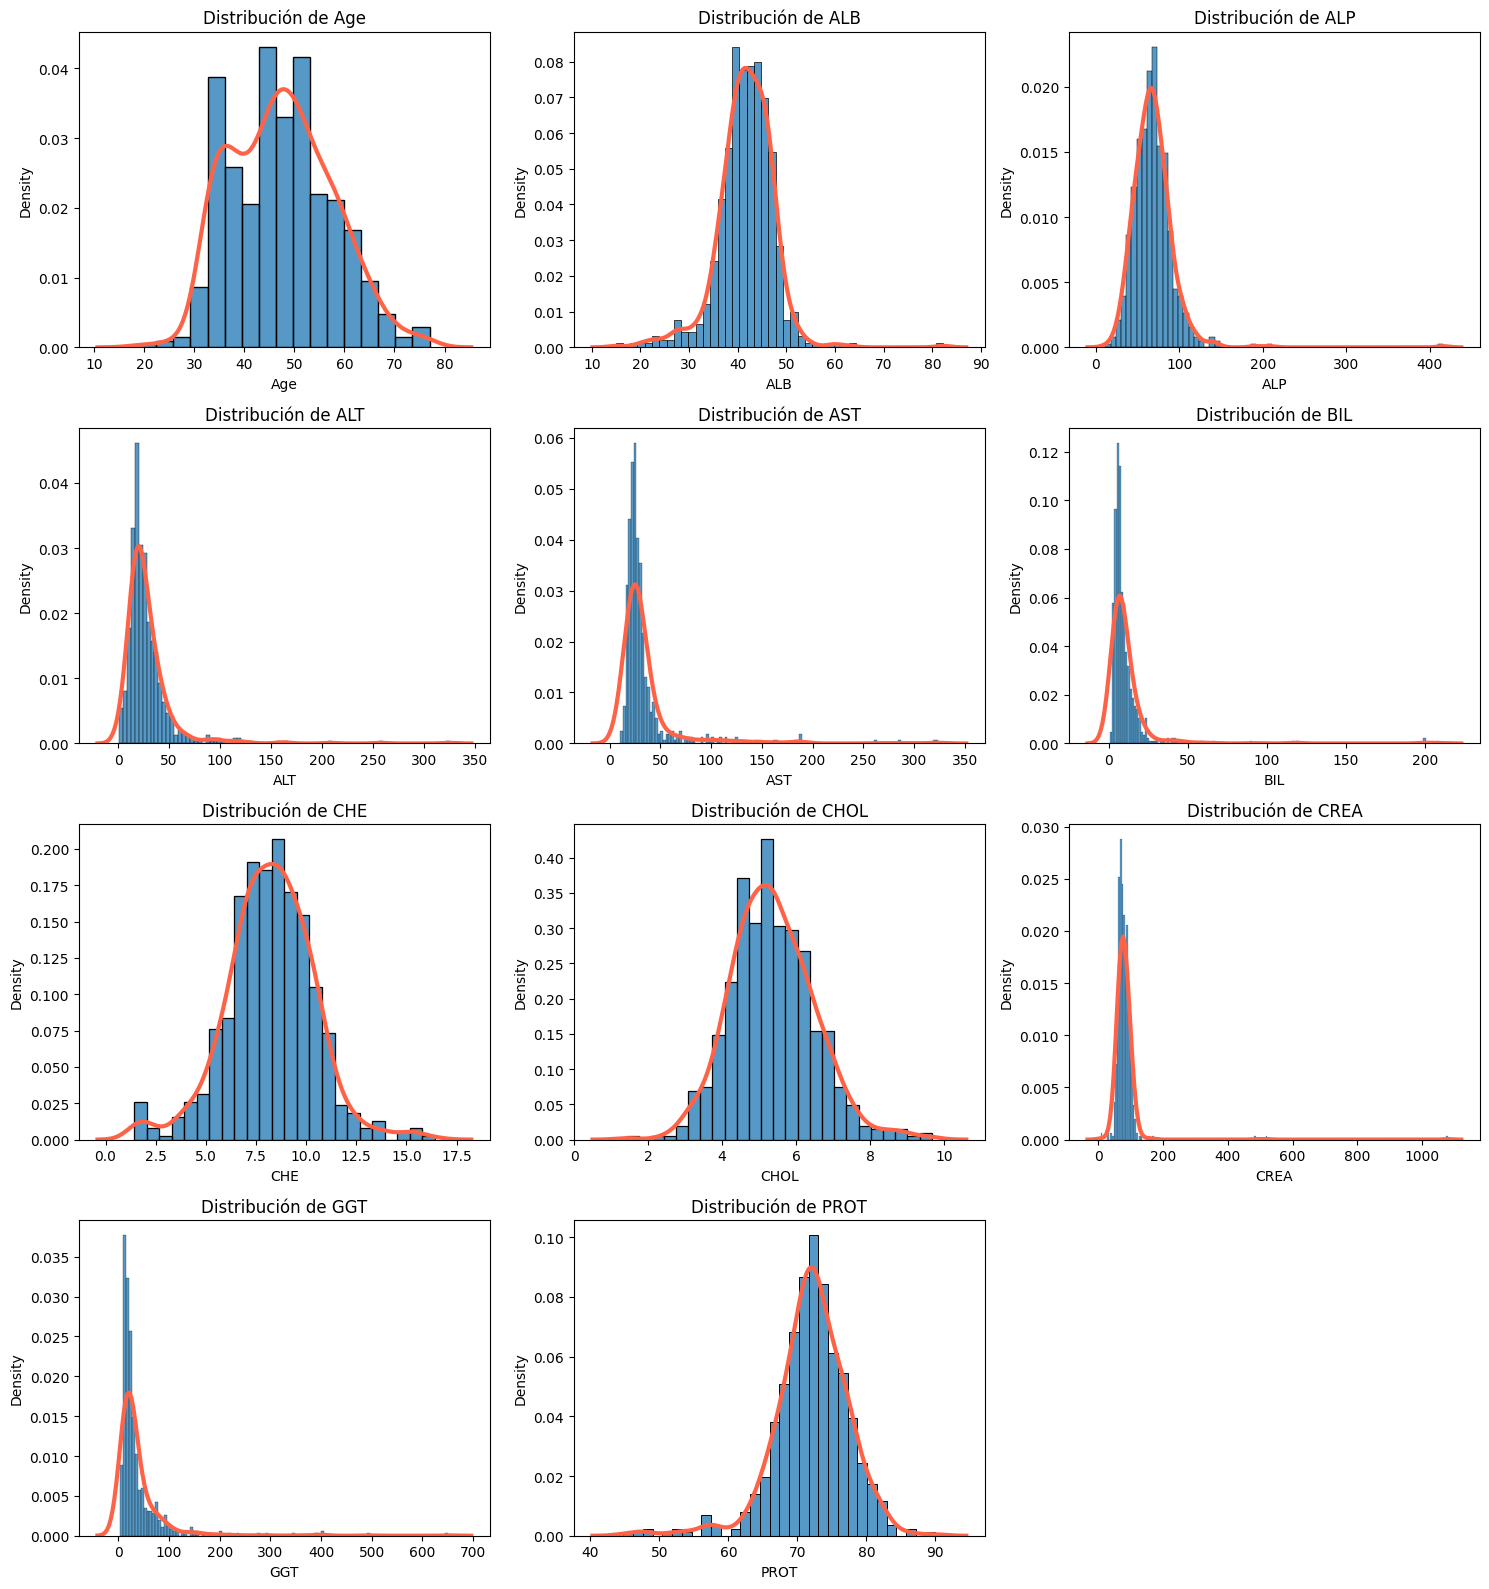

In [10]:
# e
variables_cuantitativas = ["Age", "ALB", "ALP", "ALT", "AST", "BIL", "CHE", "CHOL", "CREA", "GGT", "PROT"]
variables_cualitativas = ["Sex", "target", "suspect"]
plot_hist(df, variables_cuantitativas)

> - **Aproximadamente normales / simétricas**: ALB, CHE, CHOL, PROT distribuciones con forma de campana normal, con dispersión moderada.
>
> - **Age**: Distribución unimodal (concentrada en edades medias) y ligera cola a la derecha; no se ven outliers extremos comparado con enzimas.
>
> - **Fuertemente asimétricas a la derecha**:
ALP, ALT, AST, BIL, CREA, GGT tienen mucha masa en valores bajos-medios (cercanos a cero) y valores extremos altos (posibles outliers/influencia fuerte).


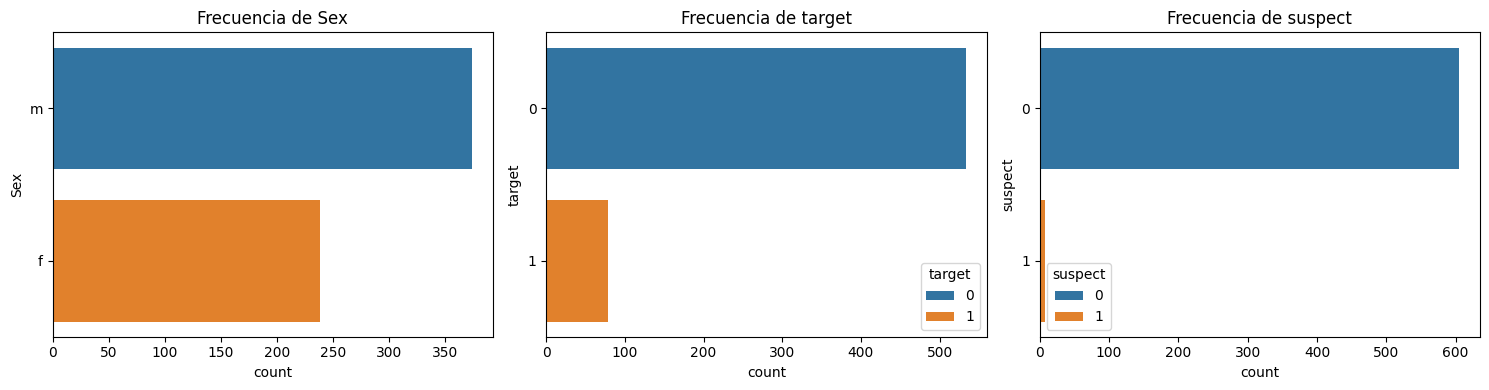

In [12]:
plot_count(df, variables_cualitativas)

> - **Target**: las clases de donador y no donador (por enfermedad) están desequilibradas.
> - **Sexo**: Existen más hombres que mujeres en este set de datos.
> - **suspect**: Casi no existen sospechosos.


### Outliers

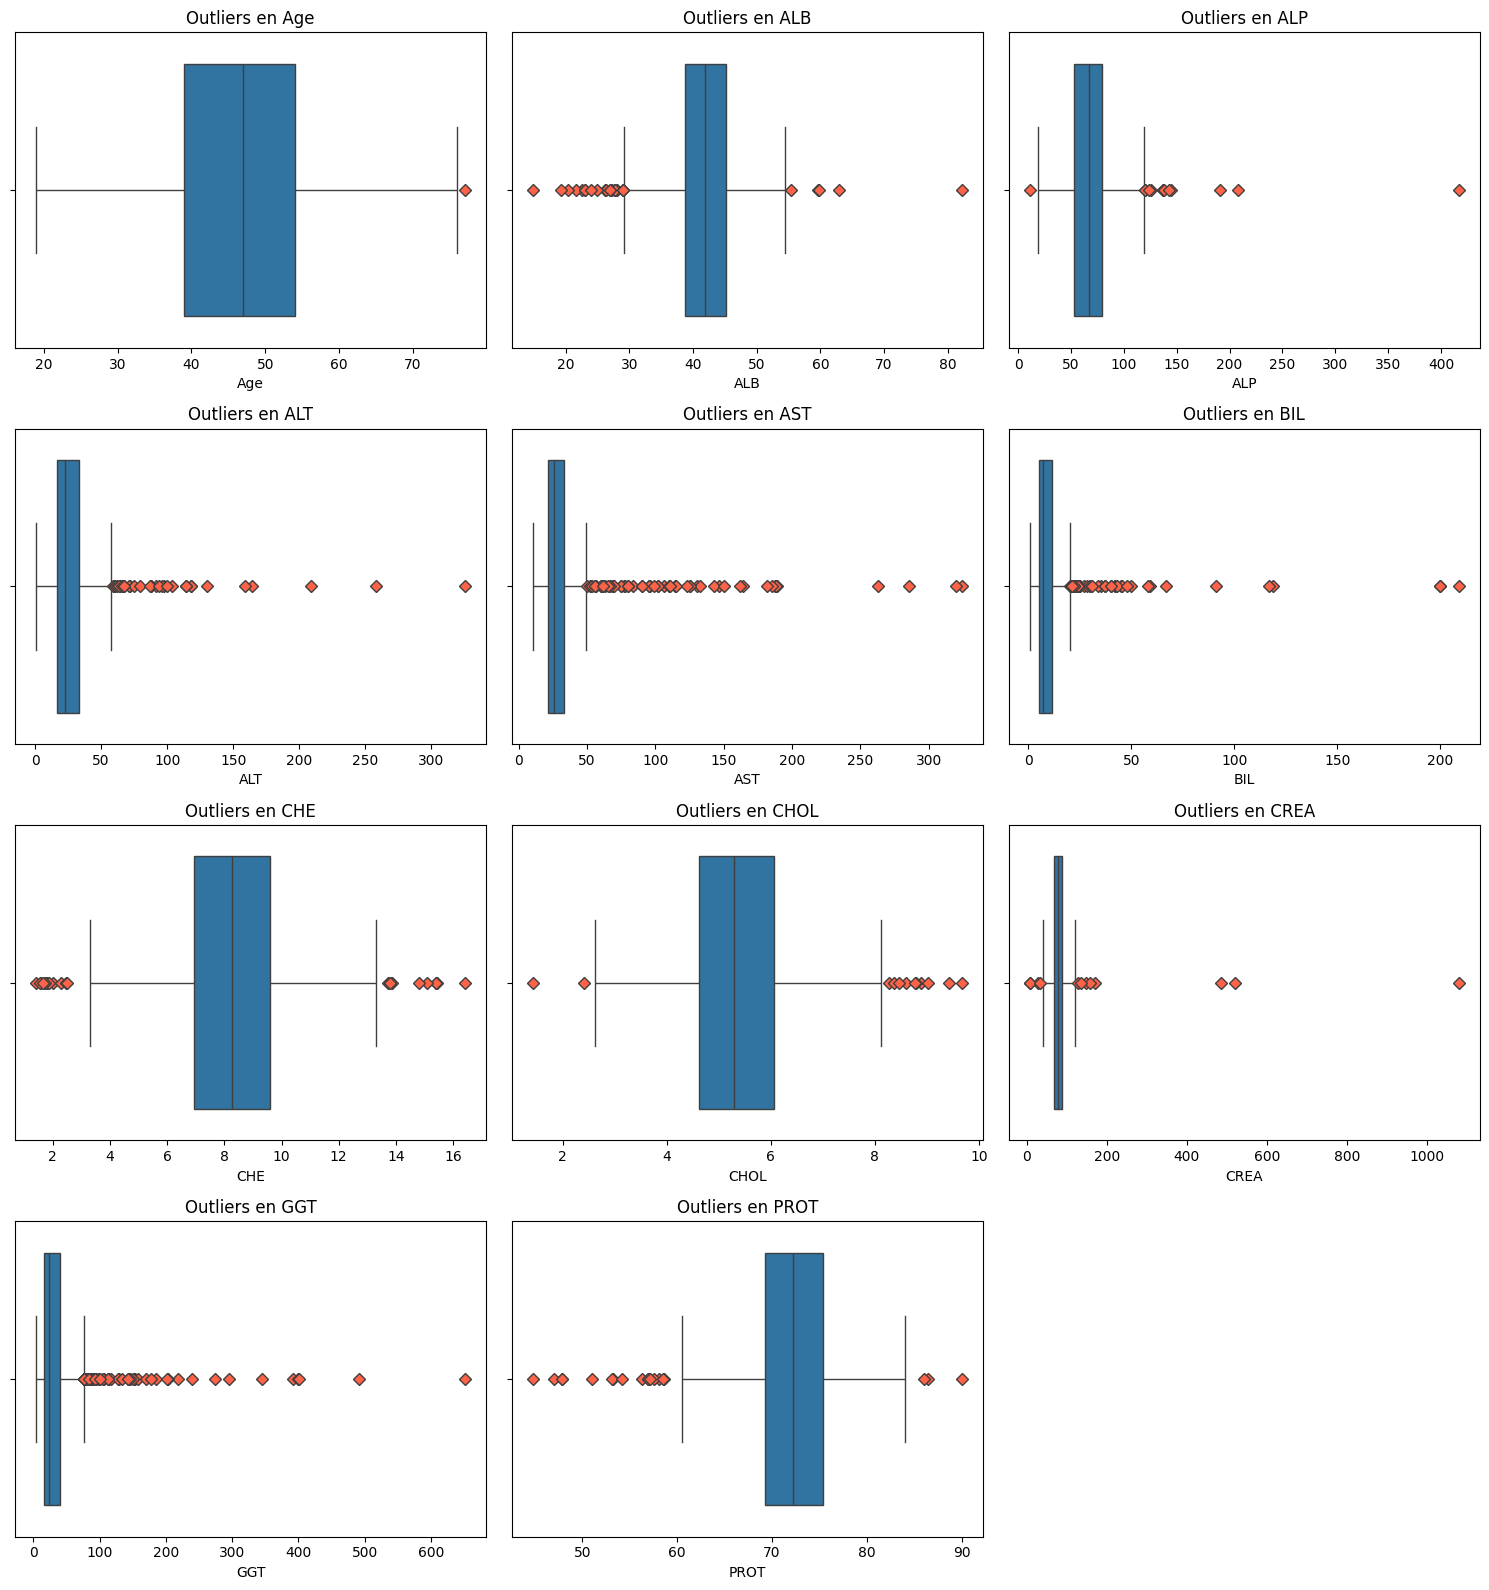

In [14]:
plot_outliers(df, variables_cuantitativas)

> Casi todas las variables presentan outliers

### Correlaciones

> Se calcula la correlación Pearson debido a que las variables en general distribuyen de forma normal

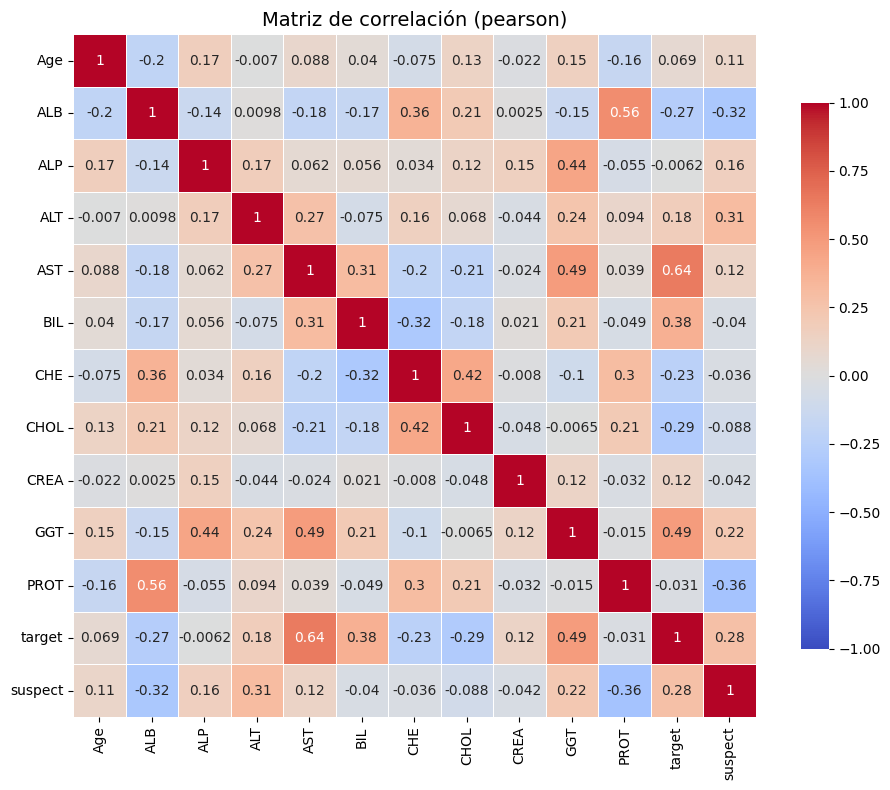

In [15]:
# Mostrar un gráfico con la matriz de correlación
plot_corr(df, method="pearson",
    figsize=(10, 8), annot=True)

> **Correlación**: Correlaciones más importantes con target (Pearson)
>
> **Más positivas** (mayor asociación con target=1)
>
> - **AST** (0.64): la relación más fuerte; a mayor AST, mayor probabilidad de pertenecer a la clase 1.
>
> - **GGT** (0.49): asociación positiva moderada-alta.
>
> - **BIL** (0.38): asociación positiva moderada.
>
> - **suspect** (0.28): positiva moderada.
>
> - **ALT** (0.18) y CREA (0.12): positivas débiles.
>
>
> **Más negativas** (mayor asociación con target=0):
>
> - **CHOL** (-0.29): la negativa más marcada. A mayor CHOL, menor probabilidad de target=1.
>
> - **ALB** (-0.27): negativa moderada.
>
> - **CHE** (-0.23): negativa moderada.
>
> **Casi sin relación lineal**:
>
> - **ALP** (-0.006), **PROT** (-0.031), **Age** (0.069): correlación prácticamente nula o muy débil con target.

### Franformación de variables (parte 1.f)

In [30]:
df.tail()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target,suspect
610,62,1,32.00,416.60,5.90,110.30,50.00,5.57,6.30,55.70,650.90,68.50,1,0
611,64,1,24.00,102.80,2.90,44.40,20.00,1.54,3.02,63.00,35.90,71.30,1,0
612,64,1,29.00,87.30,3.50,99.00,48.00,1.66,3.63,66.70,64.20,82.00,1,0
613,46,1,33.00,68.28,39.00,62.00,20.00,3.56,4.20,52.00,50.00,71.00,1,0
614,59,1,36.00,68.28,100.00,80.00,12.00,9.07,5.30,67.00,34.00,68.00,1,0


In [32]:
df_orig = df.copy()

/tmp/ipython-input-643485343.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_train[c].values for c in num_features], labels=num_features, vert=True)


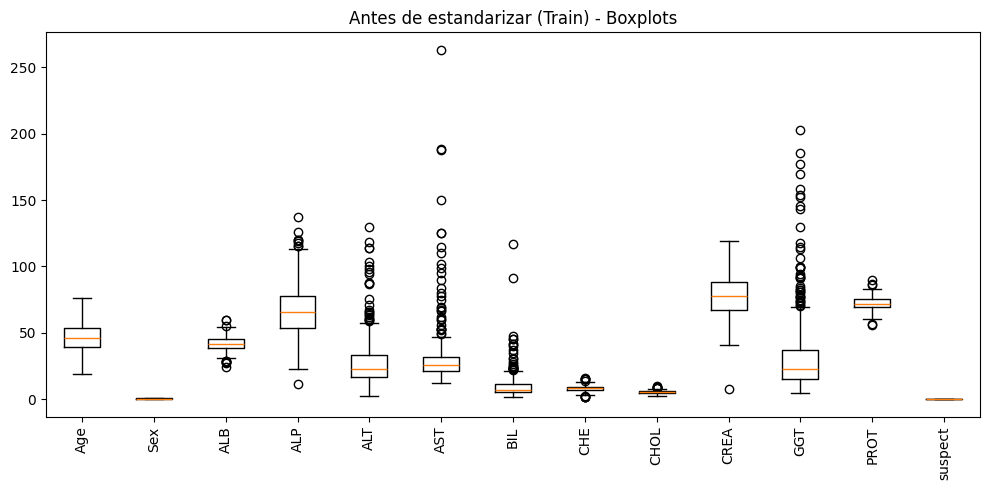

/tmp/ipython-input-643485343.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_train_scaled[c].values for c in num_features], labels=num_features, vert=True)


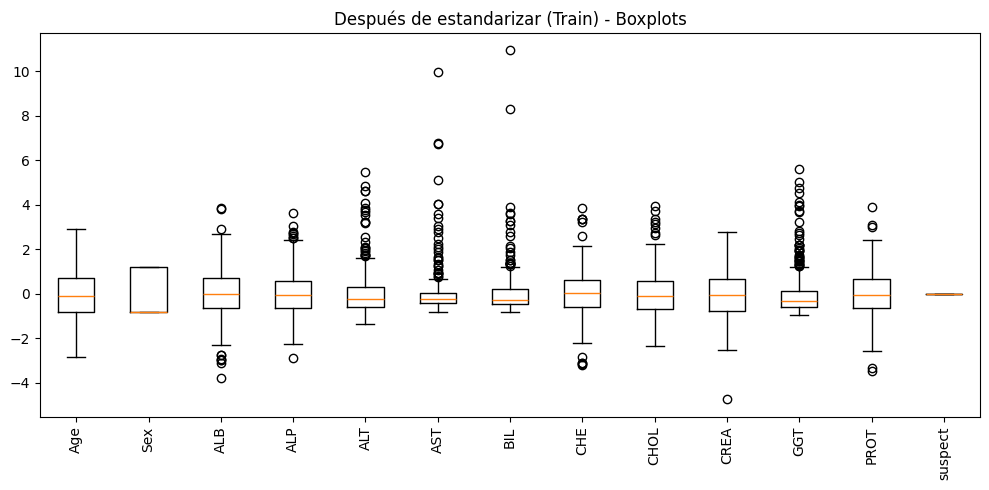

In [66]:
df = df_orig.copy()

# Convertir columna sex a númerico f=1 y m=0
df["Sex"] = (df["Sex"] == "f").astype(int)

target_col = 'target'
feature_cols = [c for c in df.columns if c != target_col]
num_features = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]

# Eliminar outliers
df = clean_outliers(df, ['ALB', 'CHE', 'CHOL', 'PROT'], _k=3.0)  # Parecen distribuciones normales
df = clean_outliers_percentiles(df, ['ALP', 'ALT', 'AST', 'BIL', 'CREA', 'GGT'], 0, 99.5)

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Split (33% test, estratificado por clase)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=42,
    stratify=y
)

# Boxplots "antes"
plt.figure(figsize=(10, 5))
plt.boxplot([X_train[c].values for c in num_features], labels=num_features, vert=True)
plt.title("Antes de estandarizar (Train) - Boxplots")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Estandarizar
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features]  = scaler.transform(X_test[num_features])

# Boxplots "después"
plt.figure(figsize=(10, 5))
plt.boxplot([X_train_scaled[c].values for c in num_features], labels=num_features, vert=True)
plt.title("Después de estandarizar (Train) - Boxplots")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [65]:
df.describe()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target,suspect
count,568.00,568.00,568.00,568.00,568.00,568.00,568.00,568.00,568.00,568.00,568.00,568.00,568.00,568.00
mean,46.88,0.40,42.08,66.44,26.61,29.82,9.11,8.37,5.42,78.07,30.36,72.37,0.08,0.00
std,9.91,0.49,4.88,18.67,16.09,18.57,6.82,2.01,1.09,14.22,24.04,4.62,0.27,0.00
min,19.00,0.00,23.00,11.30,2.10,12.00,1.80,1.54,2.40,8.00,4.50,53.20,0.00,0.00
25%,38.00,0.00,39.10,52.90,16.60,21.30,5.20,7.09,4.65,68.00,15.35,69.78,0.00,0.00
50%,46.50,0.00,42.10,66.20,22.85,25.50,7.05,8.37,5.33,76.70,22.35,72.30,0.00,0.00
75%,54.00,1.00,45.32,78.20,32.32,31.12,10.80,9.64,6.08,88.00,35.30,75.40,0.00,0.00
max,77.00,1.00,62.90,126.00,118.00,187.70,59.10,16.41,9.67,118.20,158.20,90.00,1.00,0.00


## 2. Regresión Logística

Desarrolla un modelo regresión logística con validación cruzada usando 5-fold, con
regularización Elastic Net. Busca para los siguientes hiper parámetros:

- Cs: valores entre 0.01 y 5.0, con 200 valores lineales.
- l1_ratio: valores entre 0 y 1, con 200 valores lineales.

Muestra los valores óptimos encontrados, y las métricas precisión, recall, f1-score y
accuracy. Describe cuáles son las tres características con mayor incidencia en la
predicción de sujeto o muestra con sangre con posible enfermedad.


---

In [70]:
pipe_lr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        max_iter=2000,
        random_state=42,
        class_weight="balanced"  # útil si hay desbalance
    ))
])

Cs = np.linspace(0.01, 5.0, 200)
l1_ratios = np.linspace(0.0, 1.0, 200)

param_grid = {
    "clf__C": Cs,
    "clf__l1_ratio": l1_ratios
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optimizar F1 (puedes cambiar a "accuracy" si lo necesitas)
search = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros:")
print("  C       =", search.best_params_["clf__C"])
print("  l1_ratio=", search.best_params_["clf__l1_ratio"])
print("Mejor score CV (F1):", search.best_score_)

best_lr = search.best_estimator_

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits
Mejores hiperparámetros:
  C       = 0.235678391959799
  l1_ratio= 0.7537688442211056
Mejor score CV (F1): 0.826184012066365


In [71]:
y_pred = best_lr.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nMétricas (TEST):")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}")


Métricas (TEST):
  Accuracy : 0.9845
  Precision: 0.8636
  Recall   : 1.0000
  F1-score : 0.9268


## 3. Extreme Gradient Boosting

Implementa un modelo Extreme Gradient Boosting con búsqueda de hiper
parámetros de grilla, con regularización para la combinación L1 y L2. Considera para
esto:

- a. reg_lambda: valores entre 0.0 y 2.0, con 10 valores lineales.
- b. reg_alpha: valores entre 0 y 1, con 10 valores lineales.
- c. learning_rate: valores entre 0.1 a 10, con 20 valores lineales.


---

In [72]:
# Modelo base (clasificación binaria)
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=200,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",    # rápido en CPU
)

# Grillas según enunciado
param_grid = {
    "reg_lambda": np.linspace(0.0, 2.0, 10),   # L2
    "reg_alpha":  np.linspace(0.0, 1.0, 10),   # L1
    "learning_rate": np.linspace(0.1, 10.0, 20),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="f1",      # recomendado si hay desbalance
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search_xgb.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros:")
print("  reg_lambda   =", search_xgb.best_params_["reg_lambda"])
print("  reg_alpha    =", search_xgb.best_params_["reg_alpha"])
print("  learning_rate=", search_xgb.best_params_["learning_rate"])
print("Mejor score CV (F1):", search_xgb.best_score_)

best_xgb = search_xgb.best_estimator_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Mejores hiperparámetros:
  reg_lambda   = 1.7777777777777777
  reg_alpha    = 0.2222222222222222
  learning_rate= 0.6210526315789474
Mejor score CV (F1): 0.86989010989011


In [73]:
y_pred = best_xgb.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nMétricas (TEST):")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}")


Métricas (TEST):
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1-score : 1.0000


## 4. Nivel de importancia

Muestra el nivel de importancia de los atributos, los valores óptimos de los hiper
parámetros y las métricas precisión, recall, f1-score y accuracy. Compara los
resultados de este modelo con el de regresión logística.


---

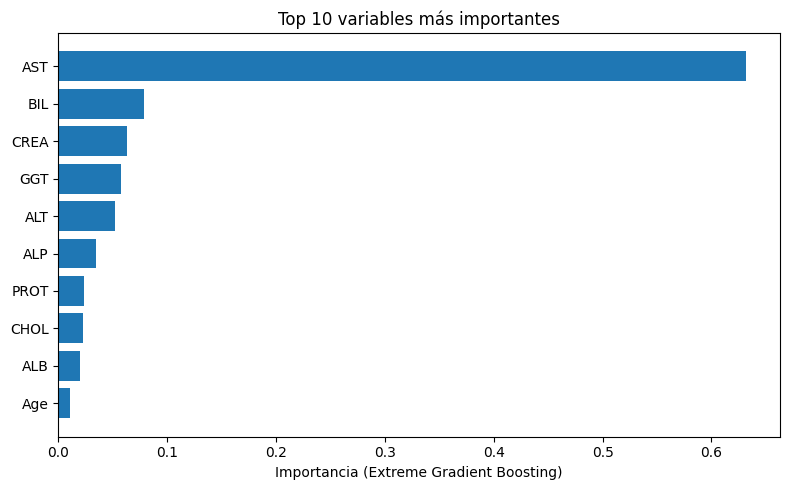

In [74]:
model = best_xgb

# Importancias
imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Top N (ajusta a gusto)
top_n = 10
imp_top = imp.head(top_n)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(imp_top.index, imp_top.values)
plt.xlabel("Importancia (Extreme Gradient Boosting)")
plt.title(f"Top {top_n} variables más importantes")
plt.tight_layout()
plt.show()

In [75]:
imp_top

,0
Age,0.01
ALB,0.02
CHOL,0.02
PROT,0.02
ALP,0.03
ALT,0.05
GGT,0.06
CREA,0.06
BIL,0.08
AST,0.63


> **Conclusiones Importancia**:
>
> - AST domina claramente el modelo (0.64 de importancia). Esto sugiere que la mayor parte de la capacidad predictiva proviene de cambios en AST, siendo el principal “gatillo” para clasificar target=1.
>
> - Segundo grupo con importancia moderada: BIL, CREA, GGT, ALT. Aportan información adicional, probablemente capturando señales complementarias.
>
> - Aporte menor: ALP y luego PROT, CHOL, ALB, Age casi residuales. Esto indica que, una vez que el modelo ya usa AST (y las del segundo grupo), estas variables agregan poco poder discriminante.
>
> - Consistencia con el heatmap/correlaciones: Que AST y GGT/BIL/ALT aparezcan arriba es coherente con su asociación previa con target (especialmente AST, que tenía la correlación más alta).

> **Conclusión entre modelos**
>
> **Regresión Logística** (Elastic Net, 5-fold)
>
> - Mejores hiperparámetros: C = 0.236, l1_ratio = 0.754
> - CV (F1): 0.826
> - Test: Accuracy 0.9845, Precision 0.8636, Recall 1.0000, F1 0.9268
> - Resultado: modelo muy sólido, con recall perfecto (no deja pasar positivos), pero con algunos falsos positivos (precision < 1).
>
> **XGBoost Classifier** (L1/L2 + grilla, 5-fold)
>
> - Mejores hiperparámetros: reg_lambda = 1.78, reg_alpha = 0.22, learning_rate = 0.621
> - CV (F1): 0.8699 (mejor que logística en validación cruzada)
> - Test: Accuracy/Precision/Recall/F1 = 1.0000
> - Resultado: desempeño perfecto en test, y mejor generalización en CV que la logística.
>
> **Conclusión final**
>
> - XGBoost es el mejor modelo porque logra mejor F1 en CV y métricas perfectas en test.
